In [366]:
# imports
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# this allows plots to appear directly in the notebook
%matplotlib inline

limit = 100000000

In [367]:
# read in data
sold = pd.read_csv('../CSV_backups/ALL-sales.csv',nrows=limit, index_col=['property_id','transaction_id']).drop_duplicates()

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Many investors generally assume that light rail construction will lift property values. We utilize a dataset of home sales in Phoenix, Arizona over 2008-2018 to study the effect of light rail operation on house property values. Valley Metro began construction in March 2005 and opened in December 2008 with 28 stations. It as since been extended to 35 stations. We evaluate the impact of proximity to a light rail station on median home prices over the past 10 years. Analysis finds that in the first six years of operation, light rail actually caused a decline in house valuations in the surrounding area, when compared to homes that were further away. It was only in 2015 and later on that the effect of light rail operation had a consistently positive impact on median home prices. We also note that the positive effect appears rather muted, with homes near rail station fetching 5.6% higher prices than homes farther away. Given the initial negative impact on prices, investors should be wary of over-bidding on properties near future train stops in anticipation of price gains in the future. For the last 9 years, homes near light rail stations appreciated at 1% higher annual rate than homes that were far away.

Map of Valley Metro Stations|
:----:|
![Map of light Rail](https://preview.ibb.co/kX2TyJ/lightrailmap.png)|

We start with a basic data set consisting of transaction data consisting of `date_closed`, `price`, `sqft`, and `dist_to_lightrail_station`. Distance to the closest light rail station is measured in kilometers, as the crow flies. We also calculate the price per squarter foot as `price_per_foot`.  

Example 1             |  Example 2
:-------------------------:|:-------------------------:
![](https://image.ibb.co/kjC6ky/dist1.png) | ![](https://image.ibb.co/kbP2Qy/dist2.png)


In [368]:
# only show properties that were actually sold (and a check to exclude those with wrong close dates e.g. >10000 days)
df = sold[(sold.date_closed != 0) & (sold.date_closed < 10000 )] \
        [["address", "date_closed","price","sqft","dist_to_lightrail_station"]]
df.rename(columns = {'date_closed':'date'}, inplace = True)

# convert days since Y2K to a nice looking date
df['date'] = df['date'].apply(lambda x: dt.date(2000, 1, 1) + dt.timedelta(days=x)) \
                       .astype("datetime64[ns]")

df = df[df.date >= dt.date(2008,12,27)]

df['ppf'] = (df.price / df.sqft)
df.head(6)

,,address,date,price,sqft,dist_to_lightrail_station,ppf
property_id,transaction_id,,,,,,
346200,23951313,"8942 N 15th Ln, Phoenix, AZ 85021",2014-10-24,400000,2388,0.700000,167.504188
9020277,23951289,"4350 W Shaw Butte Dr, Glendale, AZ 85304",2015-05-19,320000,2120,5.905930,150.943396
336902,23951266,"2125 W State Ave, Phoenix, AZ 85021",2018-03-13,285000,1723,0.844038,165.409170
990354,23951257,"1455 W Remington Dr, Chandler, AZ 85286",2017-12-05,367000,2286,13.006200,160.542432
9000471,23951250,"11774 E Mercer Ln, Scottsdale, AZ 85259",2018-01-13,369000,1502,17.024700,245.672437
9035951,23951029,"2351 W Del Oro Cir, Mesa, AZ 85202",2017-11-30,182500,1721,1.402180,106.042998


The dataset consists of 181,404 transactions dating back to the opening day of the light rail line. For this basic experiment, we will only study the effect of proximity to a light rail station on the total price of the house and the price per square foot.

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181404 entries, (346200, 23951313) to (2579, 5359)
Data columns (total 6 columns):
address                      181404 non-null object
date                         181404 non-null datetime64[ns]
price                        181404 non-null int64
sqft                         181404 non-null int64
dist_to_lightrail_station    181404 non-null float64
ppf                          181404 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 15.0+ MB


The average home in our data set sold for \$176k. There is a general filter that only includes homes between $50-400k, and between 500-10000 square feet. The dataset does not include any foreclosures or land-only transactions, but it has not been rigorously cleaned for something like the sale of a burned down house or sale of unpermitted buildings, resulting in some large variation in the price per footage. Most homes within 7km of a light rail station, with some faily long tails. This is expected - light rail goes through central areas of Phoenix, where there is highest population density and lots of existing homes. Price per foot follows a lognormal distribution, with quite a few high outliers but centered around \$102/sq ft. Square footage looks mostly like a normal distribution but there are some mansions of 3000+ ft while relatively few tiny houses.

In [370]:
df.describe(include=['datetime64','int64','float64'])

,date,price,sqft,dist_to_lightrail_station,ppf
count,181404,181404.000000,181404.000000,181404.000000,181404.000000
unique,3400,NaN,NaN,NaN,NaN
top,2017-10-25 00:00:00,NaN,NaN,NaN,NaN
freq,1208,NaN,NaN,NaN,NaN
first,2008-12-27 00:00:00,NaN,NaN,NaN,NaN
last,2018-05-15 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,175616.491158,1654.403674,7.562934,107.940965
std,NaN,86085.603240,461.070406,4.716722,48.918787
min,NaN,50000.000000,500.000000,0.000000,14.184997
25%,NaN,106611.000000,1338.000000,3.801110,70.267548


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f56ac2048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9feb6a6e10>]], dtype=object)

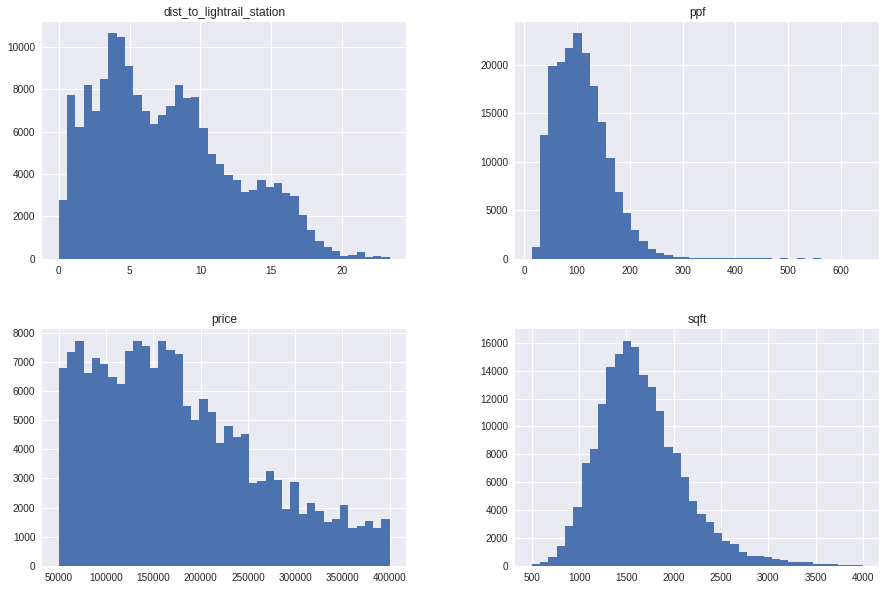

In [371]:
df.hist(bins=40,figsize=(15,10))

In terms of transaction volume by year, the dataset starts on Dec 27, 2008 and goes through May 2018. 2008 only has a few transactions since we only care about sales that closed after the rail started operating and continue through today.

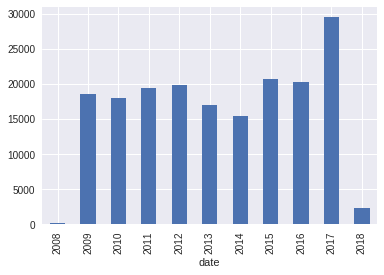

In [372]:
df.groupby(df["date"].dt.year).address.count().plot(kind="bar")

The correlation matrix shows high crosscorrelation between the `PPF` dependent variable with `price` and `sqft`. 

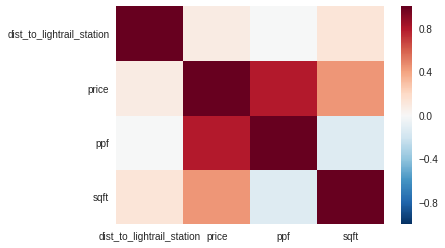

In [373]:
# Calculate and plot
numerical = list(set(df.columns) - set(['address','date']))

corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix);

The density function of price per foot and distance shows two clusters - one at around 5km away from a transit station and at average price of \$90/ft and a second, smaller one at 8km away and \$100/ft. Homes don't necessarily gain value as they get closer to a train station, but the extreme outliers that are very far away sell for lower valuations. Also homes that sell for \$200+/ft appear to be all within 5km of a train station. 

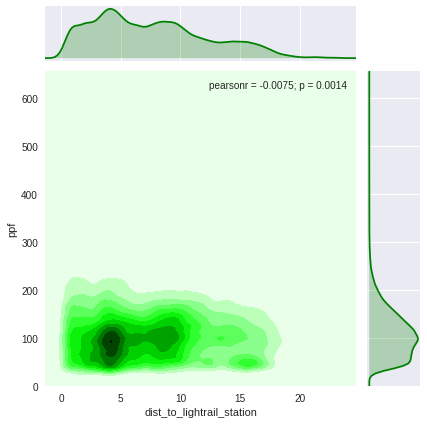

In [374]:
sns.jointplot('dist_to_lightrail_station', 'ppf', data=df, kind="kde", color="g")

Initially I had assumed that light rail would attract a less affluent resident, and that the most expensive homes would be farther away from the transit stops. Homes between \$50-100k do tend to cluster relatively closely to train stations, while homes in the \$200k+ range peak a bit farther away.

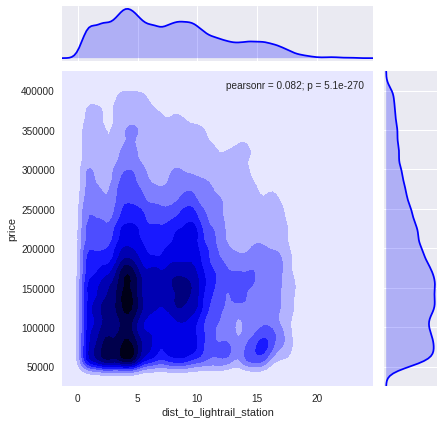

In [375]:
sns.jointplot('dist_to_lightrail_station', 'price', data=df, kind="kde", color="b")

Home sizes are normally distributed, with a slight preference for the smaller sized homes in close proximity to light rail stations.

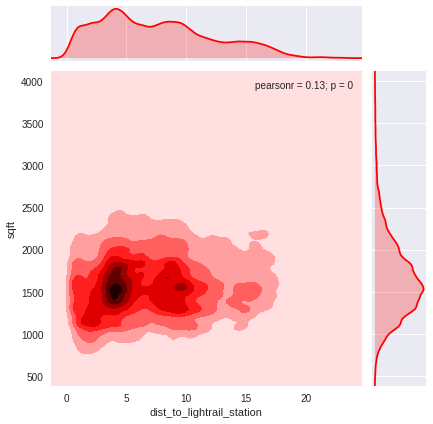

In [376]:
sns.jointplot('dist_to_lightrail_station', 'sqft', data=df, kind="kde", color="r")

Phoenix house values peaked in 2007, then declined through 2011, and have grown at very high rates since 2011. So using average price per foot metrics across the entire data set would be very misleading and we need to adjust for the general appreciation trend in the data. Creating a dummy variable to track homes that are less than 5km from a light rail station (should be either walkable or very short drive to the station) we notice that they have appreciated at a higher rate than homes that are farther away from the light rail line.

In [377]:
# create dummy variables for years and for being near a light rail station
df["year"] = df.date.dt.year
df['near_rail'] = df['dist_to_lightrail_station'] < 5

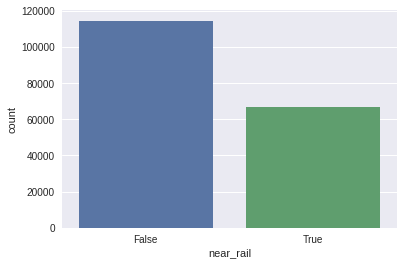

In [378]:
sns.countplot(x='near_rail', data=df)

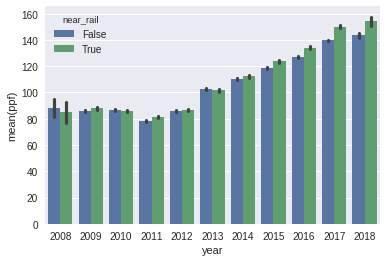

In [379]:
sns.barplot(x="year", y="ppf", hue="near_rail", data=df)

Let's start with a simple model that tries to predict price per square foot just from the total square footage and distance to light rail station. Larger homes sell for lower price per foot. Distance to light rail is actually a negative predictor of value, with every kilometer separation from station increasing price by \$0.33/ft. If true, this would be a bad news for every transit project in the country.

In [380]:
price_model = ols("price ~ sqft + sqft:dist_to_lightrail_station", data=df).fit()
# summarize our model
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                 2.242e+04
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        16:11:58   Log-Likelihood:            -2.2987e+06
No. Observations:              181404   AIC:                         4.597e+06
Df Residuals:                  181401   BIC:                         4.597e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       3.966e+04    678.523     58.447      0.000    3.83e+04     4.1e+04
sqft                              79.5241      0.449    177.172      0.000      78.644      80.404
sqft:dist_to_lightrail_station     0.3434      0.022     15.512      0.000       0.300       0.387
==============================================================================
Omnibus:                     5318.670   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5748.402
Skew:                           0.430   Prob(JB):                         0.00
Kurtosis:                       2.860   Cond. No.                     5.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [381]:
price_model = ols("price ~ sqft + sqft:near_rail", data=df).fit()
# summarize our model
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                 2.239e+04
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        16:11:58   Log-Likelihood:            -2.2987e+06
No. Observations:              181404   AIC:                         4.597e+06
Df Residuals:                  181401   BIC:                         4.597e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                3.93e+04    677.009     58.056      0.000     3.8e+04    4.06e+04
sqft                      83.4809      0.395    211.427      0.000      82.707      84.255
sqft:near_rail[T.True]    -3.0654      0.223    -13.749      0.000      -3.502      -2.628
==============================================================================
Omnibus:                     5464.543   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5928.104
Skew:                           0.438   Prob(JB):                         0.00
Kurtosis:                       2.868   Cond. No.                     6.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Earlier, we observed that prices seemed to go up faster in areas that are located close to train stations. Adding years to the regressions shows that 1) prices per foot have risen steadily from the 2011 trough and 2) impact of being near the light rail station inverted from a negative factor in 2008-2014 and is now a positive factor to valuation.

In [382]:
price_model = ols("price ~ sqft:C(year) + sqft:C(year):near_rail-1", data=df).fit()
# summarize our model
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 5.857e+04
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        16:12:01   Log-Likelihood:            -2.2778e+06
No. Observations:              181404   AIC:                         4.556e+06
Df Residuals:                  181382   BIC:                         4.556e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
sqft:C(year)[2008]                      87.4179      3.624     24.124      0.000      80.316      94.520
sqft:C(year)[2009]                      84.1891      0.369    228.042      0.000      83.466      84.913
sqft:C(year)[2010]                      84.9438      0.372    228.477      0.000      84.215      85.673
sqft:C(year)[2011]                      78.3275      0.347    225.588      0.000      77.647      79.008
sqft:C(year)[2012]                      86.3730      0.349    247.588      0.000      85.689      87.057
sqft:C(year)[2013]                     102.4858      0.391    262.229      0.000     101.720     103.252
sqft:C(year)[2014]                     109.5162      0.417    262.524      0.000     108.699     110.334
sqft:C(year)[2015]                     116.3843      0.358    324.656      0.000     115.682     117.087
sqft:C(year)[2016]                     123.5840      0.338    365.198      0.000     122.921     124.247
sqft:C(year)[2017]                     133.9002      0.272    491.554      0.000     133.366     134.434
sqft:C(year)[2018]                     136.4423      0.977    139.697      0.000     134.528     138.357
sqft:C(year)[2008]:near_rail[T.True]    -3.1717      5.948     -0.533      0.594     -14.831       8.487
sqft:C(year)[2009]:near_rail[T.True]    -1.9993      0.620     -3.223      0.001      -3.215      -0.783
sqft:C(year)[2010]:near_rail[T.True]    -4.4177      0.620     -7.124      0.000      -5.633      -3.202
sqft:C(year)[2011]:near_rail[T.True]    -0.6459      0.587     -1.100      0.271      -1.796       0.505
sqft:C(year)[2012]:near_rail[T.True]    -1.2496      0.587     -2.129      0.033      -2.400      -0.099
sqft:C(year)[2013]:near_rail[T.True]    -4.3218      0.637     -6.782      0.000      -5.571      -3.073
sqft:C(year)[2014]:near_rail[T.True]    -1.7037      0.668     -2.551      0.011      -3.012      -0.395
sqft:C(year)[2015]:near_rail[T.True]     1.5910      0.577      2.757      0.006       0.460       2.722
sqft:C(year)[2016]:near_rail[T.True]     4.5578      0.602      7.570      0.000       3.378       5.738
sqft:C(year)[2017]:near_rail[T.True]     8.0311      0.531     15.135      0.000       6.991       9.071
sqft:C(year)[2018]:near_rail[T.True]     7.7449      1.838      4.213      0.000       4.142      11.348
==============================================================================
Omnibus:                     8150.129   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9783.969
Skew:                           0.498   Prob(JB):                         0.00
Kurtosis:                       3.550   Cond. No.                         28.7
===============================================================

We can also run the model with the exact distance to a light rail station (instead of just the boolean variable), but it appears that it does not increase explanatory power. The boolean variable does just fine.

In [383]:
price_model2 = ols("price ~ sqft:C(year) + sqft:C(year):dist_to_lightrail_station-1", data=df).fit()
# summarize our model
price_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 5.851e+04
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        16:12:03   Log-Likelihood:            -2.2779e+06
No. Observations:              181404   AIC:                         4.556e+06
Df Residuals:                  181382   BIC:                         4.556e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
sqft:C(year)[2008]                              82.4369      5.429     15.185      0.000      71.797      93.077
sqft:C(year)[2009]                              85.5927      0.563    151.933      0.000      84.489      86.697
sqft:C(year)[2010]                              80.9463      0.564    143.646      0.000      79.842      82.051
sqft:C(year)[2011]                              76.6374      0.533    143.726      0.000      75.592      77.683
sqft:C(year)[2012]                              83.9288      0.536    156.661      0.000      82.879      84.979
sqft:C(year)[2013]                              98.4879      0.584    168.729      0.000      97.344      99.632
sqft:C(year)[2014]                             108.6845      0.606    179.292      0.000     107.496     109.873
sqft:C(year)[2015]                             120.0164      0.528    227.158      0.000     118.981     121.052
sqft:C(year)[2016]                             126.9022      0.553    229.668      0.000     125.819     127.985
sqft:C(year)[2017]                             140.1586      0.489    286.343      0.000     139.199     141.118
sqft:C(year)[2018]                             143.8902      1.702     84.547      0.000     140.555     147.226
sqft:C(year)[2008]:dist_to_lightrail_station     0.4577      0.554      0.826      0.409      -0.628       1.544
sqft:C(year)[2009]:dist_to_lightrail_station    -0.2631      0.060     -4.410      0.000      -0.380      -0.146
sqft:C(year)[2010]:dist_to_lightrail_station     0.3112      0.062      5.036      0.000       0.190       0.432
sqft:C(year)[2011]:dist_to_lightrail_station     0.1882      0.058      3.227      0.001       0.074       0.302
sqft:C(year)[2012]:dist_to_lightrail_station     0.2619      0.060      4.389      0.000       0.145       0.379
sqft:C(year)[2013]:dist_to_lightrail_station     0.3213      0.067      4.789      0.000       0.190       0.453
sqft:C(year)[2014]:dist_to_lightrail_station     0.0231      0.071      0.326      0.744      -0.116       0.162
sqft:C(year)[2015]:dist_to_lightrail_station    -0.4159      0.062     -6.746      0.000      -0.537      -0.295
sqft:C(year)[2016]:dist_to_lightrail_station    -0.2294      0.058     -3.943      0.000      -0.343      -0.115
sqft:C(year)[2017]:dist_to_lightrail_station    -0.4648      0.048     -9.633      0.000      -0.559      -0.370
sqft:C(year)[2018]:dist_to_lightrail_station    -0.6029      0.170     -3.538      0.000      -0.937      -0.269
==============================================================================
Omnibus:                     8206.203   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9850.646
Skew:                

We summarize the premium by year with some charts below.

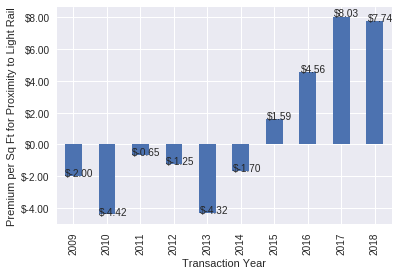

In [384]:
import re
prem = price_model.params[-10:].rename(lambda x: re.findall("\[(\d{4})\]",x)[0])
ax = prem.plot(kind="bar")
for p in ax.patches:
    b = p.get_bbox()
    val = "${:3.2f}".format(b.y1 + b.y0)
    ax.annotate(val, (p.get_x() * 1.005, p.get_height() * 1.005))
    
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['${:3.2f}'.format(x) for x in vals])
ax.set_ylabel("Premium per Sq Ft for Proximity to Light Rail")
ax.set_xlabel("Transaction Year")

      Far from Rail  Near to Rail
2009      84.189119     82.189807
2010      84.943821     80.526147
2011      78.327532     77.681597
2012      86.372985     85.123428
2013     102.485847     98.164056
2014     109.516159    107.812473
2015     116.384348    117.975318
2016     123.584016    128.141814
2017     133.900187    141.931290
2018     136.442337    144.187244


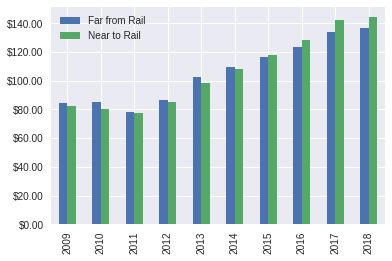

In [385]:
far_from_rail = price_model.params[-21:-11].rename(lambda x: re.findall("\[(\d{4})\]",x)[0]).rename("Far from Rail")
near_to_rail = (far_from_rail + prem).rename("Near to Rail")
output = pd.concat([far_from_rail, near_to_rail], axis=1)
print(output)
ax = output.plot(kind="bar")
vals = ax.get_yticks()
ax.set_yticklabels(['${:3.2f}'.format(x) for x in vals])


Based on this data, we can calculate the average apprerciation experienced by a home near the rail station and one farther away over the past 9 years. Homes near light rail stations appreciated at 1% higher rate than homes farther away.

In [386]:
def CAGR(first, last, periods):
    return (last/first)**(1/periods)-1
print('Price per foot CAGR of homes far from light rail stations {:.2%} '.format(CAGR(output['Far from Rail']['2009'], output['Far from Rail']['2018'], 2018-2009)))
print('Price per foot CAGR of homes near to light rail stations {:.2%} '.format(CAGR(output['Near to Rail']['2009'], output['Near to Rail']['2018'], 2018-2009)))

Price per foot CAGR of homes far from light rail stations 5.51% 
Price per foot CAGR of homes near to light rail stations 6.44% 
